<a href="https://www.kaggle.com/code/dhiaeddinesaadallah/travail-binome?scriptVersionId=274922428" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# ===============================
# 1. Chargement du Dataset
# ===============================
base_dir = "/kaggle/input/tumor-brain-classificationn"
train_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Testing")

# Génération des lots d’images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(380, 380),  # taille recommandée pour EfficientNetB4
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(380, 380),
    batch_size=32,
    class_mode='categorical'
)

# ===============================
# 2. Transfert Learning
# ===============================
base_model = EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(380, 380, 3)
)

# On gèle les couches de la base
for layer in base_model.layers:
    layer.trainable = False

# Ajout d’une tête personnalisée
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback pour stopper tôt si pas d'amélioration
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=2, verbose=1)

# Entraînement étape 1 : Transfert learning
history1 = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

# ===============================
# 3. Fine-tuning
# ===============================
# Débloquer les dernières couches pour affiner le modèle
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

# ===============================
# 4. Évaluation finale
# ===============================
loss, acc = model.evaluate(test_generator)
print(f"\n🎯 Accuracy finale sur le test : {acc:.4f}")

# Sauvegarde du modèle (optionnel)
model.save("efficientnetb4_brain_tumor.h5")


2025-11-09 22:47:08.065822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762728428.277324      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762728428.333525      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


I0000 00:00:1762728446.847590      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762728446.848353      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1762728488.505086      76 service.cc:148] XLA service 0x7c39cc002770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762728488.505858      76 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762728488.505884      76 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762728492.451761      76 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1762728498.011593      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762728498.231364      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1762728515.553700      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most onc

 48/179 ━━━━━━━━━━━━━━━━━━━━ 2:37 1s/step - accuracy: 0.5187 - loss: 1.1407

E0000 00:00:1762728579.985014      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762728580.166402      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6520 - loss: 0.8745

E0000 00:00:1762728786.023632      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762728786.246122      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


179/179 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.6525 - loss: 0.8733 - val_accuracy: 0.7384 - val_loss: 0.6640 - learning_rate: 1.0000e-04
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.8428 - loss: 0.4369 - val_accuracy: 0.8078 - val_loss: 0.5315 - learning_rate: 1.0000e-04
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.8627 - loss: 0.3814 - val_accuracy: 0.8246 - val_loss: 0.4765 - learning_rate: 1.0000e-04
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.8793 - loss: 0.3424 - val_accuracy: 0.8261 - val_loss: 0.4571 - learning_rate: 1.0000e-04
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.8913 - loss: 0.3008 - val_accuracy: 0.8581 - val_loss: 0.3920 - learning_rate: 1.0000e-04
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8893 - loss: 0.3035 - val_accuracy: 0.8528 - val_loss: 0.3967 - learning_rate: 1.0000e-04
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.90

E0000 00:00:1762730742.034969      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762730742.189232      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762730742.533400      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762730742.688087      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762730743.507256      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

 37/179 ━━━━━━━━━━━━━━━━━━━━ 2:34 1s/step - accuracy: 0.8809 - loss: 0.4594

E0000 00:00:1762730809.376929      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762730809.530746      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762730809.782894      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762730809.936761      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762730810.396727      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

179/179 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.8799 - loss: 0.4144 - val_accuracy: 0.8726 - val_loss: 0.3245 - learning_rate: 1.0000e-05
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9024 - loss: 0.2888 - val_accuracy: 0.8863 - val_loss: 0.2806 - learning_rate: 1.0000e-05
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9123 - loss: 0.2545 - val_accuracy: 0.8955 - val_loss: 0.2564 - learning_rate: 1.0000e-05
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9315 - loss: 0.2090 - val_accuracy: 0.9092 - val_loss: 0.2295 - learning_rate: 1.0000e-05
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9327 - loss: 0.1958 - val_accuracy: 0.9252 - val_loss: 0.2031 - learning_rate: 1.0000e-05
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9388 - loss: 0.1735 - val_accuracy: 0.9298 - val_loss: 0.1778 - learning_rate: 1.0000e-05
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.94

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# ===============================
# 1. Chargement du Dataset
# ===============================
base_dir = "/kaggle/input/tumor-brain-classificationn"
train_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Testing")

# Génération des lots d’images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(380, 380),   # 🔹 même taille que EfficientNetB4
    batch_size=32,            # 🔹 même batch size
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(380, 380),
    batch_size=32,
    class_mode='categorical'
)

# ===============================
# 2. Transfert Learning (VGG19)
# ===============================
base_model_vgg = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(380, 380, 3)  # 🔹 même taille d’entrée
)

# Geler toutes les couches
for layer in base_model_vgg.layers:
    layer.trainable = False

# Ajout d’une tête personnalisée
x = layers.GlobalAveragePooling2D()(base_model_vgg.output)
x = layers.Dense(512, activation='relu')(x)  # 🔹 même nombre de neurones que EfficientNetB4
x = layers.Dropout(0.5)(x)                   # 🔹 même taux de dropout
outputs = layers.Dense(train_generator.num_classes, activation='softmax')(x)

model_vgg = models.Model(inputs=base_model_vgg.input, outputs=outputs)

model_vgg.compile(
    optimizer=optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ===============================
# 3. Callbacks
# ===============================
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=2, verbose=1)

# ===============================
# 4. Entraînement - Transfert Learning
# ===============================
print("🔹 Entraînement Transfert Learning (VGG19)...")
history_vgg_tl = model_vgg.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,  # 🔹 même nombre d’époques
    callbacks=[early_stop, reduce_lr]
)

# Évaluation après transfert learning
loss_vgg_tl, acc_vgg_tl = model_vgg.evaluate(test_generator)
print(f"\n✅ Accuracy (VGG19 - Transfert Learning): {acc_vgg_tl*100:.2f}%")

# ===============================
# 5. Fine-Tuning (VGG19)
# ===============================
# Débloquer les dernières couches (on garde les premières gelées)
for layer in base_model_vgg.layers[:-50]:
    layer.trainable = False
for layer in base_model_vgg.layers[-50:]:
    layer.trainable = True  # 🔹 même nombre de couches débloquées que EfficientNetB4

model_vgg.compile(
    optimizer=optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("🔹 Entraînement Fine-Tuning (VGG19)...")
history_vgg_ft = model_vgg.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,  # 🔹 même durée d’entraînement
    callbacks=[early_stop, reduce_lr]
)

# Évaluation finale après fine-tuning
loss_vgg_ft, acc_vgg_ft = model_vgg.evaluate(test_generator)
print(f"\n✅ Accuracy (VGG19 - Fine-Tuning): {acc_vgg_ft*100:.2f}%")

# ===============================
# 6. Sauvegarde du modèle
# ===============================
model_vgg.save("vgg19_brain_tumor.h5")


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🔹 Entraînement Transfert Learning (VGG19)...
Epoch 1/10


2025-11-10 00:01:51.972777: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-10 00:01:55.344832: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.372155198s
Trying algorithm eng0{} for conv (f32[32,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

140/179 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4188 - loss: 1.8525

2025-11-10 00:05:06.369928: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-10 00:05:07.642900: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.273077632s
Trying algorithm eng0{} for conv (f32[16,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4486 - loss: 1.7293

2025-11-10 00:06:46.751631: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[31,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-10 00:06:50.093850: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.342307265s
Trying algorithm eng0{} for conv (f32[31,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

179/179 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.4493 - loss: 1.7265 - val_accuracy: 0.7910 - val_loss: 0.5821 - learning_rate: 1.0000e-04
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.7446 - loss: 0.6664 - val_accuracy: 0.8375 - val_loss: 0.4481 - learning_rate: 1.0000e-04
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.8064 - loss: 0.5091 - val_accuracy: 0.8452 - val_loss: 0.4088 - learning_rate: 1.0000e-04
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.8333 - loss: 0.4651 - val_accuracy: 0.8513 - val_loss: 0.3936 - learning_rate: 1.0000e-04
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.8536 - loss: 0.4088 - val_accuracy: 0.8551 - val_loss: 0.3733 - learning_rate: 1.0000e-04
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.8567 - loss: 0.3926 - val_accuracy: 0.8551 - val_loss: 0.3669 - learning_rate: 1.0000e-04
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.86

2025-11-10 00:44:28.998297: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-10 00:44:32.387367: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.389280266s
Trying algorithm eng0{} for conv (f32[32,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

 77/179 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - accuracy: 0.8576 - loss: 0.3885

2025-11-10 00:48:27.435606: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-10 00:48:28.677464: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.241940199s
Trying algorithm eng0{} for conv (f32[16,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

179/179 ━━━━━━━━━━━━━━━━━━━━ 527s 2s/step - accuracy: 0.8759 - loss: 0.3356 - val_accuracy: 0.9230 - val_loss: 0.2167 - learning_rate: 1.0000e-05
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.9404 - loss: 0.1707 - val_accuracy: 0.9458 - val_loss: 0.1568 - learning_rate: 1.0000e-05
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.9559 - loss: 0.1226 - val_accuracy: 0.9664 - val_loss: 0.0982 - learning_rate: 1.0000e-05
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.9618 - loss: 0.1055 - val_accuracy: 0.9664 - val_loss: 0.0937 - learning_rate: 1.0000e-05
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.9720 - loss: 0.0760 - val_accuracy: 0.9687 - val_loss: 0.1170 - learning_rate: 1.0000e-05
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.9737 - loss: 0.0670 - val_accuracy: 0.9802 - val_loss: 0.0719 - learning_rate: 1.0000e-05
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.98

🔍 DÉBUT DE LA COMPARAISON ENTRE EFFICIENTNETB4 ET VGG19

📊 Génération des prédictions...
41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 568ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 779ms/step
📈 Calcul des matrices de confusion...


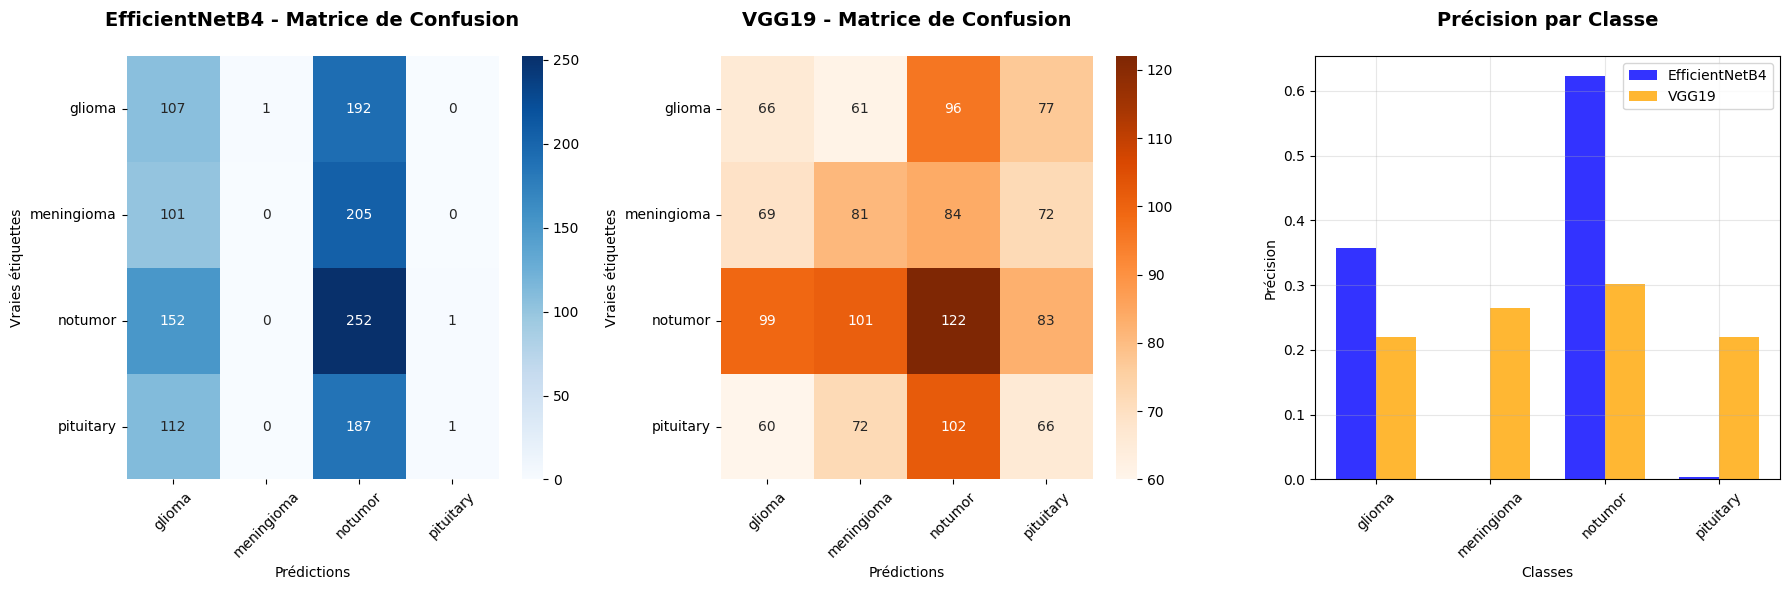


🎯 CALCUL DES MÉTRIQUES DE PERFORMANCE

RAPPORTS DÉTAILLÉS PAR CLASSE

📊 EFFICIENTNETB4 - Rapport de classification:
              precision    recall  f1-score   support

      glioma       0.23      0.36      0.28       300
  meningioma       0.00      0.00      0.00       306
     notumor       0.30      0.62      0.41       405
   pituitary       0.50      0.00      0.01       300

    accuracy                           0.27      1311
   macro avg       0.26      0.25      0.17      1311
weighted avg       0.26      0.27      0.19      1311


📊 VGG19 - Rapport de classification:
              precision    recall  f1-score   support

      glioma       0.22      0.22      0.22       300
  meningioma       0.26      0.26      0.26       306
     notumor       0.30      0.30      0.30       405
   pituitary       0.22      0.22      0.22       300

    accuracy                           0.26      1311
   macro avg       0.25      0.25      0.25      1311
weighted avg       0.26      0

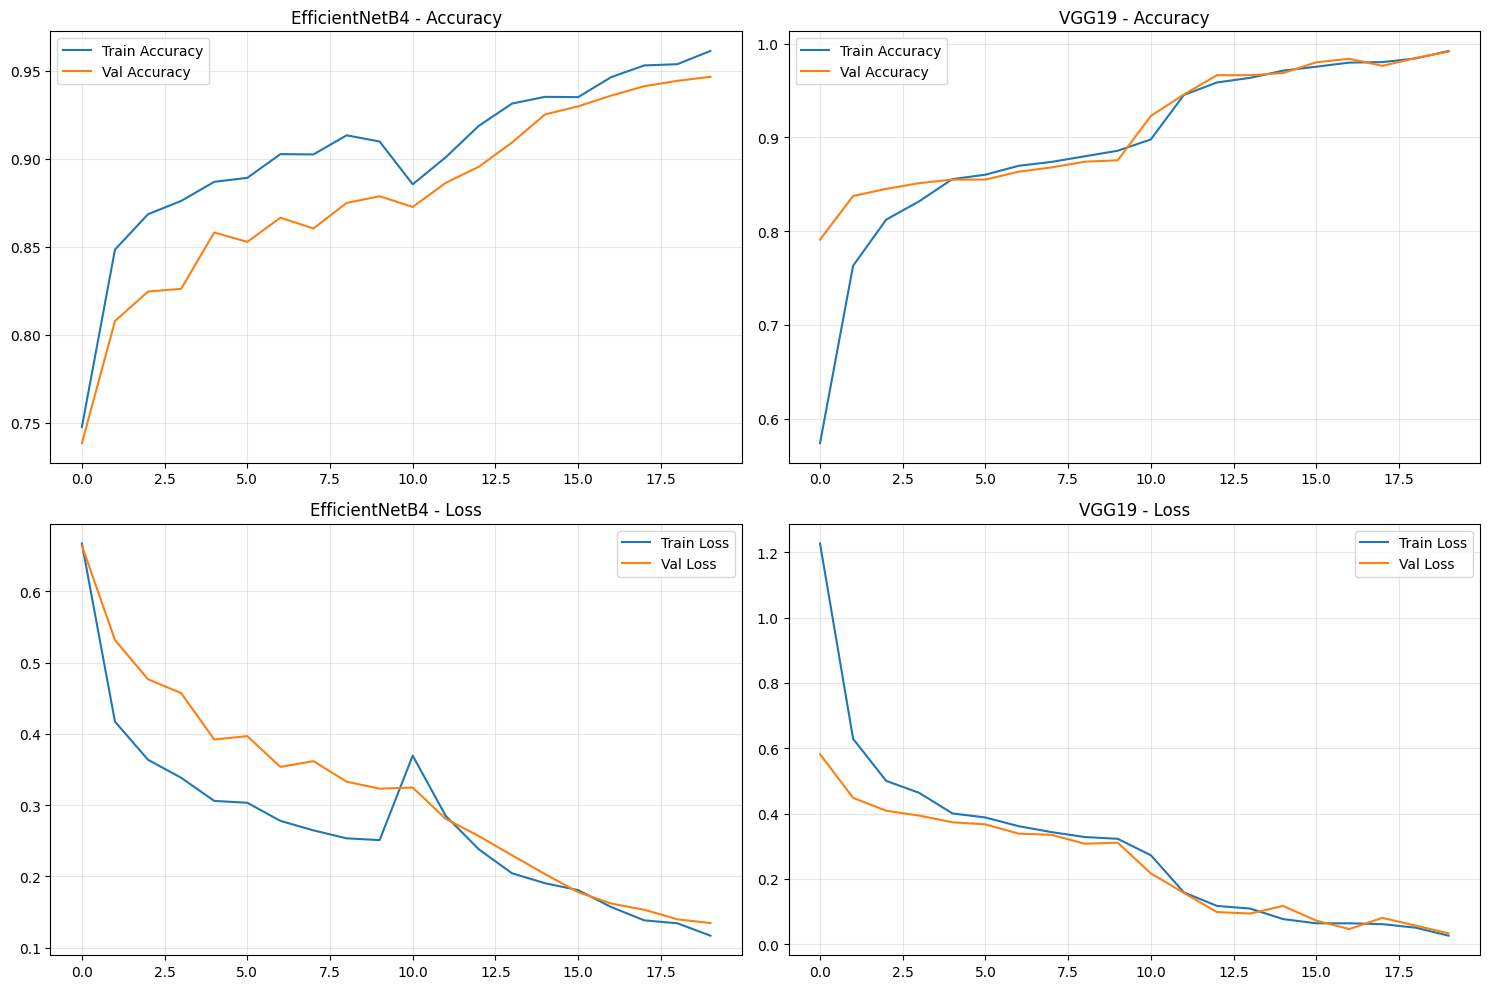


🏆 CONCLUSION FINALE
📊 Les deux modèles ont des performances similaires.
💡 Recommendation: Choisir en fonction des contraintes de calcul.

🎯 RÉSULTATTS FINAUX:
   🥇 EfficientNetB4: 27.46%
   🥈 VGG19: 25.55%

✅ Comparaison terminée avec succès!


In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ===============================
# COMPARAISON DES MODÈLES
# ===============================

print("🔍 DÉBUT DE LA COMPARAISON ENTRE EFFICIENTNETB4 ET VGG19")

# 1. Prédictions avec les deux modèles
print("\n📊 Génération des prédictions...")

# Les vrais labels
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Prédictions EfficientNetB4
y_pred_eff = np.argmax(model.predict(test_generator), axis=1)

# Prédictions VGG19
y_pred_vgg = np.argmax(model_vgg.predict(test_generator), axis=1)

# 2. Calcul des matrices de confusion
print("📈 Calcul des matrices de confusion...")
cm_eff = confusion_matrix(y_true, y_pred_eff)
cm_vgg = confusion_matrix(y_true, y_pred_vgg)

# 3. Visualisation comparative
plt.figure(figsize=(18, 6))

# Matrice de confusion EfficientNetB4
plt.subplot(1, 3, 1)
sns.heatmap(cm_eff, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('EfficientNetB4 - Matrice de Confusion\n', fontsize=14, fontweight='bold')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Matrice de confusion VGG19
plt.subplot(1, 3, 2)
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names)
plt.title('VGG19 - Matrice de Confusion\n', fontsize=14, fontweight='bold')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# 4. Comparaison des précisions par classe
acc_by_class_eff = []
acc_by_class_vgg = []

for i in range(len(class_names)):
    mask = (y_true == i)
    if np.sum(mask) > 0:
        acc_eff = np.mean(y_pred_eff[mask] == y_true[mask])
        acc_vgg = np.mean(y_pred_vgg[mask] == y_true[mask])
        acc_by_class_eff.append(acc_eff)
        acc_by_class_vgg.append(acc_vgg)

plt.subplot(1, 3, 3)
x = np.arange(len(class_names))
width = 0.35

plt.bar(x - width/2, acc_by_class_eff, width, label='EfficientNetB4', alpha=0.8, color='blue')
plt.bar(x + width/2, acc_by_class_vgg, width, label='VGG19', alpha=0.8, color='orange')

plt.xlabel('Classes')
plt.ylabel('Précision')
plt.title('Précision par Classe\n', fontsize=14, fontweight='bold')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Calcul des métriques globales
print("\n🎯 CALCUL DES MÉTRIQUES DE PERFORMANCE")

# Précisions globales
acc_eff = np.mean(y_pred_eff == y_true)
acc_vgg = np.mean(y_pred_vgg == y_true)

# Rapports détaillés
print("\n" + "="*50)
print("RAPPORTS DÉTAILLÉS PAR CLASSE")
print("="*50)

print("\n📊 EFFICIENTNETB4 - Rapport de classification:")
print(classification_report(y_true, y_pred_eff, target_names=class_names))

print("\n📊 VGG19 - Rapport de classification:")
print(classification_report(y_true, y_pred_vgg, target_names=class_names))

# 6. Affichage des résultats comparatifs
print("\n" + "="*60)
print("📈 RÉSULTATS COMPARATIFS - SYNTHÈSE")
print("="*60)

print(f"\n✅ EFFICIENTNETB4:")
print(f"   • Précision globale: {acc_eff*100:.2f}%")
print(f"   • Nombre de paramètres: {model.count_params():,}")

print(f"\n✅ VGG19:")
print(f"   • Précision globale: {acc_vgg*100:.2f}%")
print(f"   • Nombre de paramètres: {model_vgg.count_params():,}")

# 7. Analyse de la différence
diff_accuracy = (acc_eff - acc_vgg) * 100
better_model = "EfficientNetB4" if diff_accuracy > 0 else "VGG19"

print(f"\n🔥 ANALYSE COMPARATIVE:")
print(f"   • Modèle le plus performant: {better_model}")
print(f"   • Différence de précision: {abs(diff_accuracy):.2f}% en faveur de {better_model}")
print(f"   • Rapport paramètres: {model_vgg.count_params()/model.count_params():.1f}x plus de paramètres dans VGG19")

# 8. Visualisation des courbes d'apprentissage (si disponibles)
try:
    # Récupérer les historiques d'entraînement
    # Pour EfficientNetB4
    eff_history = history1.history if 'history1' in locals() else None
    eff_history_ft = history2.history if 'history2' in locals() else None
    
    # Pour VGG19
    vgg_history_tl = history_vgg_tl.history if 'history_vgg_tl' in locals() else None
    vgg_history_ft = history_vgg_ft.history if 'history_vgg_ft' in locals() else None
    
    if eff_history and vgg_history_tl:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # EfficientNetB4 - Accuracy
        if eff_history_ft:
            eff_acc = eff_history['accuracy'] + eff_history_ft['accuracy']
            eff_val_acc = eff_history['val_accuracy'] + eff_history_ft['val_accuracy']
        else:
            eff_acc = eff_history['accuracy']
            eff_val_acc = eff_history['val_accuracy']
            
        axes[0, 0].plot(eff_acc, label='Train Accuracy')
        axes[0, 0].plot(eff_val_acc, label='Val Accuracy')
        axes[0, 0].set_title('EfficientNetB4 - Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # VGG19 - Accuracy
        if vgg_history_ft:
            vgg_acc = vgg_history_tl['accuracy'] + vgg_history_ft['accuracy']
            vgg_val_acc = vgg_history_tl['val_accuracy'] + vgg_history_ft['val_accuracy']
        else:
            vgg_acc = vgg_history_tl['accuracy']
            vgg_val_acc = vgg_history_tl['val_accuracy']
            
        axes[0, 1].plot(vgg_acc, label='Train Accuracy')
        axes[0, 1].plot(vgg_val_acc, label='Val Accuracy')
        axes[0, 1].set_title('VGG19 - Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # EfficientNetB4 - Loss
        if eff_history_ft:
            eff_loss = eff_history['loss'] + eff_history_ft['loss']
            eff_val_loss = eff_history['val_loss'] + eff_history_ft['val_loss']
        else:
            eff_loss = eff_history['loss']
            eff_val_loss = eff_history['val_loss']
            
        axes[1, 0].plot(eff_loss, label='Train Loss')
        axes[1, 0].plot(eff_val_loss, label='Val Loss')
        axes[1, 0].set_title('EfficientNetB4 - Loss')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # VGG19 - Loss
        if vgg_history_ft:
            vgg_loss = vgg_history_tl['loss'] + vgg_history_ft['loss']
            vgg_val_loss = vgg_history_tl['val_loss'] + vgg_history_ft['val_loss']
        else:
            vgg_loss = vgg_history_tl['loss']
            vgg_val_loss = vgg_history_tl['val_loss']
            
        axes[1, 1].plot(vgg_loss, label='Train Loss')
        axes[1, 1].plot(vgg_val_loss, label='Val Loss')
        axes[1, 1].set_title('VGG19 - Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"\n⚠️  Impossible d'afficher les courbes d'apprentissage: {e}")

# 9. Conclusion
print("\n" + "="*60)
print("🏆 CONCLUSION FINALE")
print("="*60)

if abs(diff_accuracy) < 2:
    print("📊 Les deux modèles ont des performances similaires.")
    print("💡 Recommendation: Choisir en fonction des contraintes de calcul.")
elif diff_accuracy > 0:
    print("🏅 EfficientNetB4 est le modèle le plus performant!")
    print("💡 Avantages: Meilleure précision avec moins de paramètres.")
else:
    print("🏅 VGG19 est le modèle le plus performant!")
    print("💡 Malgré son architecture plus lourde, il obtient de meilleurs résultats.")

print(f"\n🎯 RÉSULTATTS FINAUX:")
print(f"   🥇 {better_model}: {max(acc_eff, acc_vgg)*100:.2f}%")
print(f"   🥈 {'VGG19' if better_model == 'EfficientNetB4' else 'EfficientNetB4'}: {min(acc_eff, acc_vgg)*100:.2f}%")

print("\n✅ Comparaison terminée avec succès!")